In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
# helper functions
def sample(prob):
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def normalize(arr):
    arr = np.array(arr,float)
    return arr/np.sum(arr)

def dot(x,y):
    return np.sum(np.multiply(x,y))

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
# exmples

In [4]:
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
R = np.array([8.,6.,4.])
tol = .3
# print(P)
# print(E)
print(R)

[8. 6. 4.]


In [28]:
# example 2
en = 5
ch = 4
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
# print(P)
# print(E)
print(R)

[7.  5.5 4.  6.  5. ]


In [6]:
en = 6
ch = 8
P = np.array([[.35,.2,.05,.45,.2,.15,.2,.4],[.3,.3,.2,.2,.35,.15,.05,.45],[.3,.15,.2,.25,.35,.45,.1,.2],[.35,.35,.2,.2,.2,.1,.2,.4],[.2,.15,.25,.4,.35,.15,.05,.45],[.2,.3,.2,.2,.2,.15,.3,.45],[.35,.15,.05,.45,.3,.4,.1,.2],[.2,.15,.25,.4,.4,.25,.15,.2]])/2
E = np.array([[.4,.6,.4,.3,.1,.35,.3,.4],[.3,.4,.4,.3,.3,.35,.25,.4],[.3,.2,.1,.4,.3,.4,.4,.3],[.4,.3,.3,.5,.6,.4,.55,.35],[.2,.4,.1,.3,.4,.4,.3,.1],[.4,.6,.4,.3,.6,.4,.3,.1]])/2
R = np.array([4.,3.5,4.,8.,2.,3.])
tol = .2
# print(P)
# print(E)
print(R)

[4.  3.5 4.  8.  2.  3. ]


In [ ]:
# random example generator
en = 10
ch = 8
P = row_normalize(rd.random((ch,ch)))
E = rd.rand(en,ch)/2
R = np.array(rd.randint(low=1,high=2*en,size=en),float)
# print(P)
# print(E)
print(R)
ub = np.sum(E*steady_state_prob(P),axis=1)
print(min(ub))

In [29]:
# getting optimal x using P
tol = 0.35
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

0.262507237984945
6.50100842330051 1.0 [0.] True 0.35
[0.50100842 0.         0.         0.49899158 0.        ]


In [30]:
# finding safe x by solving system of equations
xub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = xub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
print(ltemp.success)
x0 = np.transpose(row_normalize([ltemp.x])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
c_arr = []
temp_ch = [0]
for i in range(500):
    temp_ch.append(sample(P[temp_ch[-1]]))
    c_arr.append(1.0-bernoulli(E[sample(x0)][temp_ch[-1]]))
c0 = np.mean(c_arr)
print(np.sum(x0))
print(x0.flatten())
print(c0,dot(x0.flatten(),R))

True
1.0
[0.25 0.25 0.5  0.   0.  ]
0.342 5.125


In [31]:
# parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
S = 100
# x = [np.transpose([np.zeros(en)])]
# x[0][np.argmax([max(E[i])-min(E[i]) for i in range(en)])] = 1.0
x = [np.transpose(row_normalize([np.ones(en)]))]
# x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = [0]; enc = [rd.randint(en)];chnl = [rd.randint(ch)]
avg_rate = []
# markov extra param
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))

In [32]:
# algo
w = 2.5
for t in range(1,5000):
    temp_b = []
    for s in range(S):
        enc.append(sample(x[-1].transpose()[0]))
        chnl.append(sample(P[chnl[-1]]))
        temp_b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    b.append(np.mean(temp_b))
    # HMM
    model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=25, tol=1.0e-5)
    model.startprob_ = steady_state_prob(p[-1])
    step_emiss = np.sum(x[-1]*E,axis=0)
    model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
    model.transmat_ = np.copy(p[-1])
    model.fit([temp_b]) #here
    p.append(((p[-1]*float(w*(t-1)))+model.transmat_)/float(w*t-w+1))
    ub = [np.sum(E*steady_state_prob(p[-1]),axis=1)]
    tolx = 2*tol-1.0+np.mean(b)
    try:
        ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tolx],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-5}) # ,options={'tol': 1.0e-4}
    except:
        print(t,'skipped')
        break
        continue
    # print(ub[0])
    x.append(np.transpose(row_normalize([ltemp.x])))
    avg_rate.append(dot(x[-1],Rn)*R_sum)
    print(t,round(avg_rate[-1],5),round(1.0-np.mean(b),4),round(np.sum(np.abs(P-p[-1]))*100/float(ch*ch),4),ltemp.success,end='\n')
error_plot_markov = 1.0 - np.copy(b)
for i in range(1,len(error_plot_markov)):
    error_plot_markov[i] += (error_plot_markov[i-1]*(i-1))
    error_plot_markov[i] =error_plot_markov[i]/i
rate_plot_markov = np.copy(avg_rate)
for i in range(1,len(rate_plot_markov)):
    rate_plot_markov[i] += (rate_plot_markov[i-1]*(i-1))
    rate_plot_markov[i] =rate_plot_markov[i]/i

1 4.0 0.68 9.7119 False
2 4.0 0.5533 10.4994 False
3 4.0 0.4875 10.232 False
4 4.0 0.454 10.2664 False
5 4.0 0.4317 10.5199 False
6 5.26145 0.4143 10.7455 True
7 5.38469 0.4075 10.9576 True
8 6.04236 0.3856 10.6878 True
9 6.04153 0.384 10.8407 True
10 6.18452 0.3709 10.6557 True
11 6.25181 0.3642 10.5896 True
12 6.23398 0.3654 10.6349 True
13 6.20308 0.3679 10.6976 True
14 6.17627 0.37 10.7487 True
15 6.25643 0.3625 10.6509 True
16 6.24281 0.3635 10.6668 True
17 6.21827 0.3656 10.7138 True
18 6.2483 0.3626 10.6891 True
19 6.31005 0.357 10.5972 True
20 6.31706 0.3562 10.5965 True
21 6.33332 0.3545 10.5793 True
22 6.36828 0.3513 10.5217 True
23 6.40023 0.3483 10.4623 True
24 6.41214 0.3472 10.4435 True
25 6.39939 0.3485 10.4419 True
26 6.36167 0.3522 10.4781 True
27 6.33696 0.3546 10.5125 True
28 6.3672 0.3517 10.4658 True
29 6.37437 0.351 10.4623 True
30 6.36503 0.3519 10.4647 True
31 6.3685 0.3516 10.457 True
32 6.35617 0.3527 10.4743 True
33 6.38142 0.3503 10.4365 True
34 6.39945 0.34

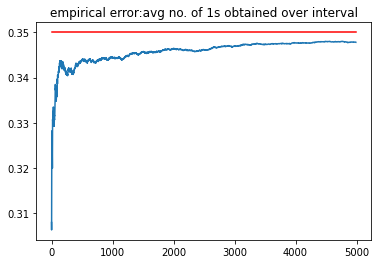

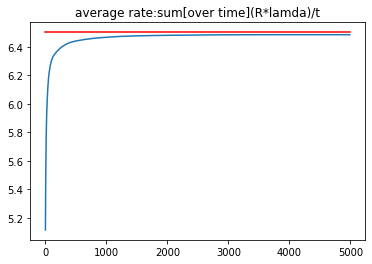

In [33]:
stat = 10
end = 5000
org_rate = dot(org_x,R)
plt.plot(error_plot_markov[stat:end])
plt.plot([0,len(error_plot_markov[stat:end])],[tol,tol],'r')
plt.title('empirical error:avg no. of 1s obtained over interval')
plt.show()
plt.plot(rate_plot_markov[stat:end])
plt.plot([0,len(rate_plot_markov[stat:end])],[org_rate,org_rate],'r')
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [34]:
print(x0.flatten())
print('--------------------------------------------------------------------------')
print(x[end-2].flatten())
print(org_x)
print(error_plot_markov[end-2],tol)
print(rate_plot_markov[end-2],avg_rate[end-2],dot(org_x,R))

[0.25 0.25 0.5  0.   0.  ]
--------------------------------------------------------------------------
[0.4843998 0.        0.        0.5156002 0.       ]
[0.50100842 0.         0.         0.49899158 0.        ]
0.34779111644656907 0.35
6.483806330885901 6.48445035425125 6.50100842330051


0.010066111907728624


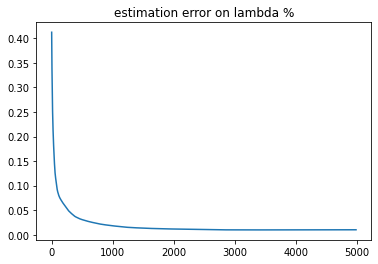

In [35]:
# error plot when compared to optimal x
err = []
for i in range(len(x)):
    err.append(np.sqrt(np.sum(np.square(org_x-x[i].flatten()))/en))
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[stat:end])
plt.title('estimation error on lambda %')
plt.show()

0.09375 0.09496014861894603


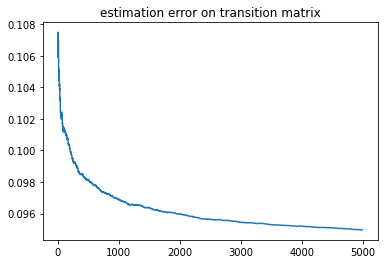

In [36]:
# transition matrix error
err = []
for i in range(len(p)):
    err.append(np.sum(np.abs(P-p[i]))/float(ch*ch))
print(err[0], err[-1])
plt.plot(err[stat:end])
plt.title('estimation error on transition matrix')
plt.show()

In [37]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.001 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = []; enc = [];chnl = [rd.randint(ch)]
avg_rate = []

In [38]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
sprob = steady_state_prob(p[-1])
tolx = tol
for t in range(1,5000):
    temp_b = []
    for s in range(S):
        enc.append(sample(x[-1].transpose()[0]))
        chnl.append(sample(P[chnl[-1]]))
        temp_b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    b.append(np.mean(temp_b))
    r.append(dot(x[-1],Rn))
    c.append(1.0 - b[-1])
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    ub = ((c0/norm_x0)*e0_trans)+muopt.transpose()-(dot(e0,muopt)*e0_trans)
    betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    val = alfa_c*betat*linalg.norm(xopt)
    if t > 100:
        tolx = 2.0*tol - np.mean(c)
    try:
        ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tolx-val],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
    except:
        print(t,'skipped')
        break
        continue
    # print(ub[0])
    x.append(np.transpose(row_normalize([ltemp.x])))
    avg_rate.append(dot(x[-1],Rn)*R_sum)
    print(t,round(avg_rate[-1],5),round(1.0-np.mean(b),4),ltemp.success,end='\n')
error_plot_oplb = 1.0 - np.copy(b)
for i in range(1,len(error_plot_oplb)):
    error_plot_oplb[i] += (error_plot_oplb[i-1]*(i-1))
    error_plot_oplb[i] =error_plot_oplb[i]/i
rate_plot_oplb = np.copy(avg_rate)
for i in range(1,len(rate_plot_oplb)):
    rate_plot_oplb[i] += (rate_plot_oplb[i-1]*(i-1))
    rate_plot_oplb[i] =rate_plot_oplb[i]/i

1 7.0 0.26 True
2 6.88808 0.335 True
3 6.86126 0.3467 True
4 6.81524 0.36 True
5 6.78977 0.364 True
6 6.7418 0.3717 True
7 6.7474 0.3671 True
8 6.71897 0.37 True
9 6.71027 0.3689 True
10 6.72014 0.365 True
11 6.62468 0.3764 True
12 6.73963 0.3675 True
13 6.73595 0.3662 True
14 6.7105 0.3671 True
15 6.74067 0.3627 True
16 6.77989 0.3569 True
17 6.76036 0.3588 True
18 6.76302 0.3578 True
19 6.72868 0.3621 True
20 6.68331 0.3675 True
21 6.6898 0.3657 True
22 6.65996 0.3686 True
23 6.6661 0.367 True
24 6.64084 0.3692 True
25 6.62877 0.3696 True
26 6.62759 0.3688 True
27 6.63303 0.3674 True
28 6.65193 0.3643 True
29 6.64846 0.3641 True
30 6.6303 0.366 True
31 6.58996 0.37 True
32 6.57873 0.3703 True
33 6.60013 0.3676 True
34 6.60172 0.3668 True
35 6.57096 0.3694 True
36 6.57009 0.3689 True
37 6.56907 0.3684 True
38 6.55018 0.3695 True
39 6.54921 0.369 True
40 6.53871 0.3692 True
41 6.52776 0.3695 True
42 6.62578 0.3695 True
43 6.512 0.3721 True
44 6.51318 0.3714 True
45 6.48305 0.3724 True


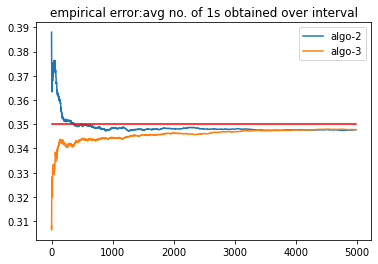

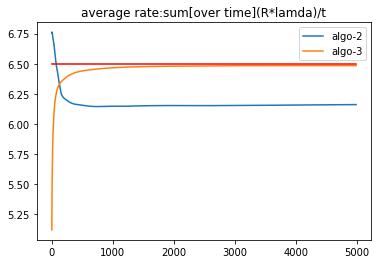

In [39]:
stat = 10
end = 5000
org_rate = dot(org_x,R)
plt.plot(error_plot_oplb[stat:end])
plt.plot(error_plot_markov[stat:end])
plt.plot([0,len(error_plot_oplb[stat:end])],[tol,tol],'r')
plt.legend(['algo-2', 'algo-3'])
plt.title('empirical error:avg no. of 1s obtained over interval')
plt.show()
plt.plot(rate_plot_oplb[stat:end])
plt.plot(rate_plot_markov[stat:end])
plt.legend(['algo-2', 'algo-3'])
plt.plot([0,len(rate_plot_oplb[stat:end])],[org_rate,org_rate],'r')
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [40]:
print(rate_plot_markov[end-2],rate_plot_oplb[end-2],dot(org_x,R))

6.483806330885901 6.159641823032183 6.50100842330051


In [ ]:
# Rough